In [68]:
import sys
sys.path.append("/home/dux/")
sys.path.append("/home/dux/surface_sampling/mcmc")

from ase.build import make_supercell
from ase.io import read, write

import catkit
from catkit.gen.adsorption import get_adsorption_sites

from mcmc import mcmc_run
import os
import numpy as np

from ase.visualize.plot import plot_atoms
from ase.visualize import view
from matplotlib import pyplot as plt

os.environ["PROJECT_DIR"] = os.getcwd()

In [69]:
# SrTiO3 from HTVS db
import sys
import os
import django
import numpy as np
# from tqdm import tqdm
# import pandas as pd
# import pickle as pkl
sys.path.append('/home/dux/htvs/')
sys.path.append('/home/dux/htvs/djangochem/')

#from imports import *
#from django_imports import *
# from pymatgen.core.periodic_table import Element
# from chemconfigs.vasp.defaults import Magmom
# from ase.visualize import view

# setup the django settings file.  Change this to use the settings file that connects you to your desired database
os.environ["DJANGO_SETTINGS_MODULE"] = "djangochem.settings.orgel"
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"  # CAUTION!!! LINE NECESSARY WHEN INTERACTING WITH DATABASE IN JUPYTER NOTEBOOK. DO NOT USE THIS LINE IF YOU ARE PLANNING ON SAVING/REMOVING THINGS FROM THE DATABASE!!!!!

# this must be run to setup access to the django settings and make database access work etc.
django.setup()
# from jobs.models import Job, JobConfig
# from django.contrib.contenttypes.models import ContentType
# from ase.io import write

from pgmols.models import Surface
# from analysis.structure.perovskite import PerovskiteAnalyzer
# from pymatgen.core.periodic_table import Element

unit_slab = Surface.objects.get(id=217485271).as_ase_gratoms()
unit_slab.write('SrTiO3_001_pristine_slab.cif')

# get supercell
# multiplier = np.diag([2, 2, 1])
# slab = make_supercell(unit_slab, multiplier)
slab = unit_slab*(2,2,1)
slab.write('SrTiO3_001_2x2_pristine_slab.cif')

In [70]:
# Pymatgen adsorption sites for InGaN
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

from ase.io import read, write

pristine_slab = slab
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)
# AdsorbateSiteFinder(slab, selective_dynamics=False, height=0.9, mi_vec=None)
sites = site_finder.find_adsorption_sites(put_inside=False, symm_reduce=False)
# find_adsorption_sites(distance=2.0, put_inside=True, symm_reduce=0.01, near_reduce=0.01, positions=['ontop', 'bridge', 'hollow'], no_obtuse_hollow=True)

In [71]:
for type in sites.keys():
    print(f"{type} sites has total {len(sites[type])}")

ontop sites has total 12
bridge sites has total 36
hollow sites has total 16
all sites has total 64


In [72]:
ads_positions = sites['all']
# print(f"adsorption coordinates are")
# print(ads_positions)
# take just the first 18 sites after inspection
# select_positions = ads_positions[:18]

# take all positions
select_positions = ads_positions

In [73]:
# adsorb onto the sites
from pymatgen.core.structure import Molecule
ads_mol = Molecule(['O'], [[0, 0, 0]])
for ads_coord in select_positions:
    slab = site_finder.add_adsorbate(ads_mol, ads_coord, repeat=None, translate=False, reorient=False)
    site_finder.slab = slab

from pymatgen.io.cif import CifWriter
# write out slab
cif_slab = CifWriter(site_finder.slab)
# cif_slab.write_file("pymatgen_SrTiO3_001_4x4_O_all_adsorbed_slab.cif")
cif_slab.write_file("pymatgen_SrTiO3_001_2x2_O_all_adsorbed_slab.cif")

In [74]:
all_adsorbed = read("pymatgen_SrTiO3_001_2x2_O_all_adsorbed_slab.cif")
print(f"all adsorbed {len(all_adsorbed)}")

all adsorbed 124


In [75]:
len(select_positions)

64

In [76]:
len(pristine_slab)

60

Testing oxygens

In [25]:
from mcmc import filter_distances
element = 'O'

False

In [50]:
def visualize_slabs(pristine, test):
    fig, ax = plt.subplots(1, 2, figsize=(10,10))
    labels = ['pristine', 'test adsorbed']
    for i in range(2):
        ax[i].axis('off')
        ax[i].set_title(labels[i])
    plot_atoms(pristine_slab, 
                ax[0], 
                radii=0.8, 
                rotation=("90x, 15y, 90z"))
    plot_atoms(test_slab, 
                ax[1], 
                radii=0.8, 
                rotation=("90x, 15y, 90z"))

Test one oxygen

In [51]:
test_slab = pristine_slab.copy() # starting with a pristine slab

# adsorb at one site
site1 = [1.96777,   1.04845,  19.25570]

test_slab.append(element)
test_slab.positions[-1] = site1

filter_distances(test_slab, pristine_len=len(pristine_slab), cutoff_distance=1.5)

True

Test two oxygens fail

In [52]:
test_slab = pristine_slab.copy() # starting with a pristine slab

# adsorb at two sites
site1 = [1.96777,   1.04845,  19.25570]
site2 = [0.98388,   0.96100,  19.29980]

test_slab.append(element)
test_slab.positions[-1] = site1
test_slab.append(element)
test_slab.positions[-1] = site2

filter_distances(test_slab, pristine_len=len(pristine_slab), cutoff_distance=1.5)

False

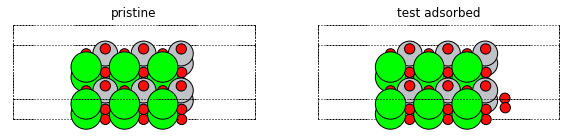

In [53]:
# visualize the adsorption sites
visualize_slabs(pristine_slab, test_slab)

Test two oxygens pass

In [54]:
test_slab = pristine_slab.copy() # starting with a pristine slab

# adsorb at two sites
site1 = [1.96777,   1.04845,  19.25570]
site2 = [2.95164,   2.95350,  19.29980]

test_slab.append(element)
test_slab.positions[-1] = site1
test_slab.append(element)
test_slab.positions[-1] = site2

filter_distances(test_slab, pristine_len=len(pristine_slab), cutoff_distance=1.5)

True

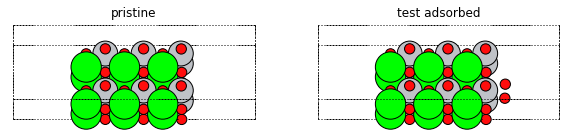

In [55]:
visualize_slabs(pristine_slab, test_slab)

Test three oxygens fail

In [56]:
test_slab = pristine_slab.copy() # starting with a pristine slab

# adsorb at three sites
site1 = np.array([1.96777,   1.04845,  19.25570])
site2 = np.array([0.98388,   0.96100,  19.29980])
site3 = np.array([2.95164,   2.95350,  19.29980])

test_slab.append(element)
test_slab.positions[-1] = site1
test_slab.append(element)
test_slab.positions[-1] = site2
test_slab.append(element)
test_slab.positions[-1] = site3

filter_distances(test_slab, pristine_len=len(pristine_slab), cutoff_distance=1.5)

False

In [57]:
# confirm
print(f"Distance between sites 1 and 2 {np.linalg.norm(site1-site2)}")
print(f"Distance between sites 1 and 3 {np.linalg.norm(site1-site3)}")
print(f"Distance between sites 2 and 3 {np.linalg.norm(site2-site3)}")

Distance between sites 1 and 2 0.9887526710962656
Distance between sites 1 and 3 2.1445653381046705
Distance between sites 2 and 3 2.8003813432459514


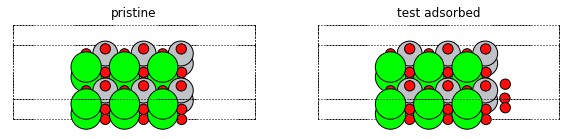

In [58]:
visualize_slabs(pristine_slab, test_slab)

Test three oxygens pass

In [63]:
test_slab = pristine_slab.copy() # starting with a pristine slab

# adsorb at three sites
site1 = np.array([1.96777,   1.04845,  19.25570])
site2 = np.array([3.93553,   3.95573,  19.32035])
site3 = np.array([5.90331,   5.03345,  19.25570])

test_slab.append(element)
test_slab.positions[-1] = site1
test_slab.append(element)
test_slab.positions[-1] = site2
test_slab.append(element)
test_slab.positions[-1] = site3

filter_distances(test_slab, pristine_len=len(pristine_slab), cutoff_distance=1.5)

True

In [64]:
# confirm
print(f"Distance between sites 1 and 2 {np.linalg.norm(site1-site2)}")
print(f"Distance between sites 1 and 3 {np.linalg.norm(site1-site3)}")
print(f"Distance between sites 2 and 3 {np.linalg.norm(site2-site3)}")

Distance between sites 1 and 2 3.5112015092415305
Distance between sites 1 and 3 5.600776740024548
Distance between sites 2 and 3 2.24450844268851


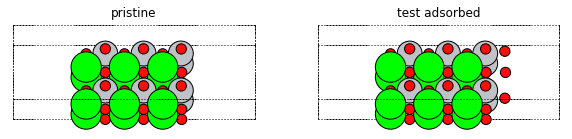

In [65]:
visualize_slabs(pristine_slab, test_slab)